In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
from pybullet_envs.bullet.kukaGymEnv import KukaGymEnv
import random
import os
from gym import spaces
import time
import pybullet as p
from pybullet_envs.bullet import kuka
import numpy as np
import pybullet_data
import pdb
import distutils.dir_util
import glob
from pkg_resources import parse_version
import gym

current_dir=C:\Users\Kami\anaconda3\envs\robot_grasping\lib\site-packages\pybullet_envs\bullet


In [3]:
class KukaDiverseObjectEnv(KukaGymEnv):
    def __init__(self,
                urdfRoot=pybullet_data.getDataPath(),
                actionRepeat=80,
                isEnableSelfCollision=True,
                renders=False,
                isDiscrete=False,
                maxSteps=8,
                dv=0.06,
                removeHeightHack=False,
                blockRandom=0.3,
                cameraRandom=0,
                width=48,
                height=48,
                numObjects=5,
                isTest=False,
                from_pixels=False):
        
        self._isDiscrete = isDiscrete
        self._timeStep = 1. / 240.
        self._urdfRoot = urdfRoot
        self._actionRepeat = actionRepeat
        self._isEnableSelfCollision = isEnableSelfCollision
        self._observation = []
        self._envStepCounter = 0
        self._renders = renders
        self._maxSteps = maxSteps
        self.terminated = 0
        self._cam_dist = 1.3
        self._cam_yaw = 180
        self._cam_pitch = -40
        self._dv = dv
        self._p = p
        self._removeHeightHack = removeHeightHack
        self._blockRandom = blockRandom
        self._cameraRandom = cameraRandom
        self._width = width
        self._height = height
        self._numObjects = numObjects
        self._isTest = isTest
        
        self._from_pixels = from_pixels
        
        
        if self._renders:
            self.cid = p.connect(p.SHARED_MEMORY)
            if (self.cid < 0):
                self.cid = p.connect(p.GUI)
            p.resetDebugVisualizerCamera(1.3, 180, -41, [0.52, -0.2, -0.33])
        
        else:
            self.cid = p.connect(p.DIRECT)
        self.seed()
        
        if (self._isDiscrete):
            if self._removeHeightHack:
                self.action_space = spaces.Discrete(9)
            else:
                self.action_space = spaces.Discrete(7)
        else:
            self.action_space = spaces.Box(low=-1, high=1, shape=(3,)) # dx, dy, da
            if self._removeHeightHack:
                self.action_space = spaces.Box(low=-1, high=1, shape=(4,))  # dx, dy, dz, da
                
        self.observation_space = spaces.Box(low=0, high=255, shape=(self._height,
                                                                self._width,
                                                                3))
        self.viewer = None
    
    def reset(self):
        look = [0.23, 0.2, 0.54]
        distance = 1.
        pitch = -56 + self._cameraRandom * np.random.uniform(-3, 3)
        yaw = 245 + self._cameraRandom * np.random.uniform(-3, 3)
        roll = 0
        self._view_matrix = p.computeViewMatrixFromYawPitchRoll(look, distance, yaw, pitch, roll, 2)
        fov = 20. + self._cameraRandom * np.random.uniform(-2, 2)
        aspect = self._width / self._height
        near = 0.01
        far = 10
        self._proj_matrix = p.computeProjectionMatrixFOV(fov, aspect, near, far)

        self._attempted_grasp = False
        self._env_step = 0
        self.terminated = 0

        p.resetSimulation()
        p.setPhysicsEngineParameter(numSolverIterations=150)
        p.setTimeStep(self._timeStep)
        p.loadURDF(os.path.join(self._urdfRoot, "plane.urdf"), [0, 0, -1])

        p.loadURDF(os.path.join(self._urdfRoot, "table/table.urdf"), 0.5000000, 0.00000, -.820000,
                   0.000000, 0.000000, 0.0, 1.0)

        p.setGravity(0, 0, -10)
        self._kuka = kuka.Kuka(urdfRootPath=self._urdfRoot, timeStep=self._timeStep)
        self._envStepCounter = 0
        p.stepSimulation()
        
        urdfList = self._get_random_object(self._numObjects, self._isTest)
        self._objectUids = self._randomly_place_objects(urdfList)
        self._observation = self._get_observation()
        return np.array(self._observation)

    def _randomly_place_objects(self, urdfList):
        objectUids = []
        for urdf_name in urdfList:
            xpos = 0.4 + self._blockRandom * random.random()
            ypos = self._blockRandom * (random.random() - .5)
            angle = np.pi / 2 + self._blockRandom * np.pi * random.random()
            orn = p.getQuaternionFromEuler([0, 0, angle])
            urdf_path = os.path.join(self._urdfRoot, urdf_name)
            uid = p.loadURDF(urdf_path, [xpos, ypos, .15], [orn[0], orn[1], orn[2], orn[3]])
            objectUids.append(uid)
            
            for _ in range(500):
                p.stepSimulation()
        return objectUids
    
    def _get_observation(self):
        if self._from_pixels:
#             obs = super()._get_observation()
            img_arr = p.getCameraImage(width=self._width,
                                      height=self._height,
                                      viewMatrix=self._view_matrix,
                                      projectionMatrix=self._proj_matrix)
            rgb = img_arr[2]
            np_img_arr = np.reshape(rgb, (self._height, self._width,4))
            o = np_img_arr[:, :, :3]
            return o.transpose(2,0,1)
        else:
            o = self._kuka.endEffectorPos + [self._kuka.endEffectorAngle]
            for uid in self._objectUids:
                pos, quaternion = self._p.getBasePositionAndOrientation(uid)
                o += list(pos)
                o += list(quaternion)
            return np.array(o)
    
    def step(self, action):
        dv = self._dv
        if self._isDiscrete:
            assert isinstance(action, int)
            if self._removeHeightHack:
                dx = [0, -dv, dv, 0, 0, 0, 0, 0, 0][action]
                dy = [0, 0, 0, -dv, dv, 0, 0, 0, 0][action]
                dz = [0, 0, 0, 0, 0, -dv, dv, 0, 0][action]
                da = [0, 0, 0, 0, 0, 0, 0, -0.25, 0.25][action]
            else:
                dx = [0, -dv, dv, 0, 0, 0, 0][action]
                dy = [0, 0, 0, -dv, dv, 0, 0][action]
                dz = -dv
                da = [0, 0, 0, 0, 0, -0.25, 0.25][action]
        else:
            dx = dv * action[0]
            dy = dv * action[1]
            if self._removeHeightHack:
                dz = dv * action[2]
                da = 0.25 * action[3]
            else:
                dz = -dv
                da = 0.25 * action[2]
        
        return self._step_continuous([dx, dy, dz, da, 0.3])
    
    def _step_continuous(self, action):
        self._env_step += 1
        self._kuka.applyAction(action)
        for _ in range(self._actionRepeat):
            p.stepSimulation()
            if self._renders:
                time.sleep(self._timeStep)
            if self._termination():
                break
                
        state = p.getLinkState(self._kuka.kukaUid, self._kuka.kukaEndEffectorIndex)
        end_effector_pos = state[0]
        if end_effector_pos[2] <= 0.1:
            finger_angle = 0.3
            for _ in range(500):
                grasp_action = [0, 0, 0, 0, finger_angle]
                self._kuka.applyAction(grasp_action)
                p.stepSimulation()
                finger_angle -= 0.3 / 100.
                if finger_angle < 0:
                    finger_angle = 0
            for _ in range(500):
                grasp_action = [0, 0, 0.001, 0, finger_angle]
                self._kuka.applyAction(grasp_action)
                p.stepSimulation()
                if self._renders:
                    time.sleep(self._timeStep)
                finger_angle -= 0.3 / 100.
                if finger_angle < 0:
                    finger_angle = 0
            self._attempted_grasp = True
        observation = self._get_observation()
        done = self._termination()
        reward = self._reward()

        debug = {'grasp_success': self._graspSuccess}
        return observation, reward, done, debug
    
    def _reward(self):
        reward = 0
        self._graspSuccess = 0
        for uid in self._objectUids:
            pos, _ = p.getBasePositionAndOrientation(uid)
            if pos[2] > 0.2:
                self._graspSuccess += 1
                reward = 1
                break
        return reward
    
    def _termination(self):
        return self._attempted_grasp or self._env_step >= self._maxSteps
    
    def _get_random_object(self, num_objects, test):
        if test:
            urdf_pattern = os.path.join(self._urdfRoot, 'random_urdfs/*0/*.urdf')
        else:
            urdf_pattern = os.path.join(self._urdfRoot, 'random_urdfs/*[1-9]/*.urdf')
        found_object_directories = glob.glob(urdf_pattern)
        total_num_objects = len(found_object_directories)
        selected_objects = np.random.choice(np.arange(total_num_objects), num_objects)
        selected_objects_filenames = []
        for object_index in selected_objects:
            selected_objects_filenames += [found_object_directories[object_index]]
        return selected_objects_filenames
    
    if parse_version(gym.__version__) < parse_version('0.9.6'):
        _reset = reset
        _step = step

In [7]:
env = KukaDiverseObjectEnv(renders=False,
                           width=64,
                           height=64,
                           numObjects=1,
                           from_pixels=False
                          )

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU IS AVAILABLE :D') 
else:  
    device = torch.device("cpu") 
    print('GPU not available')

GPU IS AVAILABLE :D


In [14]:
Transition = namedtuple('Transition',
                       ('state',
                       'action',
                       'next_state',
                       'reward'))

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        "save a transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [15]:
class DQN(nn.Module):
    def __init__(self): 
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(11, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 32)
        
        self.fc4 = nn.Linear(3, 32)
        
        self.fc5 = nn.Linear(32 + 32, 32)
        self.fc6 = nn.Linear(32, 1)
        
        
    def forward(self, s, a): 
        s = s.to(device)
        a = a.to(device)

        s = F.relu(self.fc1(s))
        s = F.relu(self.fc2(s))
        s = F.relu(self.fc3(s))
        
        a = F.relu(self.fc4(a))
        
        val = torch.cat((s, a), axis=1)
        val = F.relu(self.fc5(val))
        
        return self.fc6(val)

In [18]:
env.reset()

BATCH_SIZE = 16
GAMMA = 0.9
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 50


policy_net = DQN().to(device) 
target_net = DQN().to(device) 
target_net.load_state_dict(policy_net.state_dict()) 
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayBuffer(50000)

In [19]:
steps_done = 0

In [20]:
import operator

In [21]:
def CrossEntropyMethod(state,
                       sample_fn,
                      objective_fn,
                      update_fn,
                      initial_params,
                      num_elites,
                      num_iterations=1,
                      threshold_to_terminate=None):
    
    updated_params = initial_params
    
    for _ in range(num_iterations):
        samples = sample_fn(**updated_params) # used for dictionaries to give arguments
        
        values = objective_fn(samples, state)
        
        if isinstance(samples, dict):
            sample_order = [i for i, _ in sorted(enumerate(values), key=operator.itemgetter(1))]
           
            sorted_samples = {k: [v[i] for i in sample_order] for k,v in sample.items()}
            
            elite_samples = {k:v[-num_elites:] for k, v in sorted_samples.items()}
            
        else:
            sorted_samples = [s for s, _ in sorted(zip(samples,values), key=operator.itemgetter(1))]
                
            elite_samples = sorted_samples[-num_elites:]
                
        updated_params = update_fn(elite_samples)
            
        if ((threshold_to_terminate is not None) and (max(values) > threshold_to_terminate)):
            break
                
    return samples, values, updated_params

In [22]:
class CEM_policy(object):
    def __init__(self,
                state, 
                batch_size=64,
                action_size=3):
    
        self.batch_size = batch_size
        self._action_size = action_size

        self._action_space = spaces.Box(low=-1, high=1, shape=(3,))
        
    def sample_action(self, state):
            
        def objective_fn(sample, state):
            state = state.tile(64,).reshape(64, 11)
            sample = torch.tensor(sample, dtype=torch.float)
            q_values = policy_net(state, sample)
            
            return q_values

        def sample_fn(mean, std):
            return mean + std * np.random.randn(self.batch_size, self._action_size)

        def update_fn(elite_samples):
            return {'mean': np.mean(elite_samples, axis=0),
                   'std': np.std(elite_samples, axis=0, ddof=1)}

        global steps_done
        mu = np.zeros(3)
        mu[2] = -1
        initial_params = {'mean': mu, 'std': .5 * np.ones(3)}
        sample, values, final_params = CrossEntropyMethod(state,
                                                          sample_fn,
                                                         objective_fn,
                                                         update_fn,
                                                         initial_params,
                                                         num_elites=10,
                                                         num_iterations=3)
        
        idx = torch.argmax(values.detach().cpu())
        best_cont_actions, best_cont_vals = sample[idx], values[idx]
        steps_done += 1

        return best_cont_actions

CEM = CEM_policy(env.reset())

In [23]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE) 
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch, action_batch) #.gather(1, action_batch) 

    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    next_state_values[non_final_mask] = target_net(non_final_next_states, action_batch).max(1)[0].detach() 
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch 
    
    criterion = nn.SmoothL1Loss() 
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [24]:
def test(num_episodes=50, max_episode_length=15):
    successes = 0
    for i_episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float)
        
        for t in range(max_episode_length):
            action = CEM.sample_action(state)
            next_state, reward, done, _ = env.step(action)
            
            if reward == 1:
                successes += 1
            
            state = torch.tensor(next_state, dtype=torch.float)
            
            if done:
                break
            
    return successes

In [25]:
def Agent(num_episodes=1, max_episode_length=15, save_every=500):
    episode_durations = []
    eps_history = []
    rewards = []
    success_rates = []
    
    for i_episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float)
        
        for t in range(max_episode_length):
            action = CEM.sample_action(state)
            next_state, reward, done, _ = env.step(action) 
            
            reward = torch.tensor([reward], device=device)
            next_state = torch.tensor(next_state, dtype=torch.float)
            action = torch.tensor(action, dtype=torch.float)
            memory.push(state.unsqueeze(0), action.unsqueeze(0), next_state.unsqueeze(0), reward)
            
            state = next_state
            
            optimize_model()
            
            if done:
                episode_durations.append(t+1)
                break
        
        rewards.append(reward.item())
        
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if i_episode % save_every == 0:
            torch.save(policy_net.state_dict(), 'State obs Policy-net DQN.pt')
            torch.save(target_net.state_dict(), 'State obs Target-net DQN.pt')
        
        if (i_episode + 1) % 125 == 0:
            success_per_1000 = test()
            success_rates.append(success_per_1000)
            print("Episode: ", i_episode + 1, "/", num_episodes, (success_per_1000/50)*100)
    
    final_success = test()
    success_rates.append(final_success)
    
    torch.save(policy_net.state_dict(), 'State obs Policy-net DQN.pt')
    torch.save(target_net.state_dict(), 'State obs Target-net DQN.pt')
    print('Complete')
    return episode_durations, rewards, success_rates

In [26]:
eps_durations, rewards, success_rates = Agent(num_episodes=12500)

Episode:  125 / 12500 0.0
Episode:  250 / 12500 0.0
Episode:  375 / 12500 0.0
Episode:  500 / 12500 0.0
Episode:  625 / 12500 0.0
Episode:  750 / 12500 2.0
Episode:  875 / 12500 4.0
Episode:  1000 / 12500 4.0
Episode:  1125 / 12500 6.0
Episode:  1250 / 12500 12.0
Episode:  1375 / 12500 2.0
Episode:  1500 / 12500 6.0
Episode:  1625 / 12500 4.0
Episode:  1750 / 12500 0.0
Episode:  1875 / 12500 10.0
Episode:  2000 / 12500 12.0
Episode:  2125 / 12500 14.000000000000002
Episode:  2250 / 12500 10.0
Episode:  2375 / 12500 12.0
Episode:  2500 / 12500 12.0
Episode:  2625 / 12500 6.0
Episode:  2750 / 12500 12.0
Episode:  2875 / 12500 2.0
Episode:  3000 / 12500 12.0
Episode:  3125 / 12500 14.000000000000002
Episode:  3250 / 12500 10.0
Episode:  3375 / 12500 12.0
Episode:  3500 / 12500 16.0
Episode:  3625 / 12500 16.0
Episode:  3750 / 12500 6.0
Episode:  3875 / 12500 4.0
Episode:  4000 / 12500 6.0
Episode:  4125 / 12500 16.0
Episode:  4250 / 12500 12.0
Episode:  4375 / 12500 10.0
Episode:  4500 / 

In [27]:
success_percent = (np.array(success_rates)/50) * 100

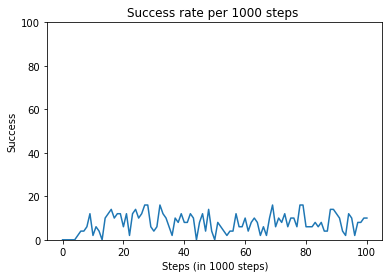

In [28]:
plt.plot(np.arange(len(success_percent)), success_percent)
plt.xlabel('Steps (in 1000 steps)')
plt.ylabel('Success')
plt.title('Success rate per 1000 steps ')
plt.ylim(0,100)
plt.show()